In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.ncol = ncol
        self.nrow = nrow
        self.x = 0
        self.y = self.nrow - 1

    def step(self, action):
        # 4 actions: change[0]: up, change[1]: down, change[2]: left, change[3]: right
        # (0, 0) is top-left corner
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        terminal = False
        if self.y == self.nrow - 1 and self.x > 0: # cliff or goal
            terminal = True
            if self.x < self.ncol - 1: # cliff
                reward = -100
        return next_state, reward, terminal
    
    def reset(self): # reset to start state
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [ ]:
### SARSA algorithm
# use Q_table to store Q values of all state-action pairs
# sampling policy: epsilon-greedy
# improvement policy: temporal difference
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_actions=4):
        self.Q_table = np.zeros([nrow * ncol, n_actions]) # initialize Q table
        self.epsilon = epsilon # probability of choosing random action
        self.alpha = alpha # learning rate
        self.gamma = gamma # discount factor
        self.n_actions = n_actions

    def take_action(self, state):
        if np.random.rand() < self.epsilon: # choose random action
            action = np.random.choice(self.n_actions)
        else: # choose action with highest Q value
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state): # print best action for each state
        Q_max = np.max(self.Q_table[state]) # maximum Q value for current state
        action = [0 for _ in range(self.n_actions)]
        for a in range(self.n_actions):
            if self.Q_table[state][a] == Q_max: # find best action
                action[a] = 1 # record as best action
        return action # return list of best actions (1: best action, 0: not best action)
    
    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1][a1] - self.Q_table[s0][a0]
        self.Q_table[s0][a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 500/500 [00:00<00:00, 30548.46it/s, episode=500, return=-18.900]


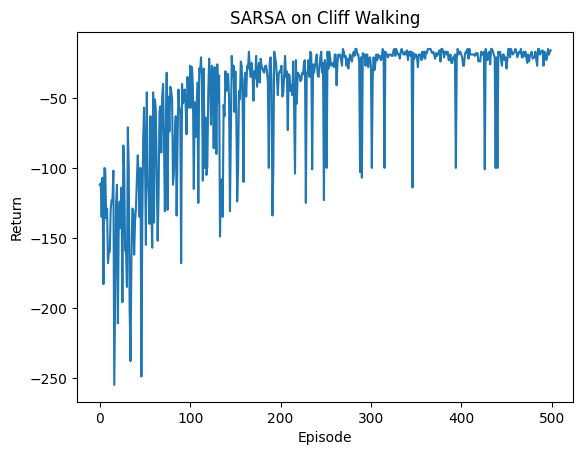

In [ ]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = [] # record the return of each episode

for i in range(10):
    with tqdm(total=num_episodes, desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)): # divide by 10 to show progress bar
            episode_return = 0 # return of current episode
            state = env.reset()
            action = agent.take_action(state) # choose action based on current state by epsilon-greedy
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                agent.update(state, action, reward, next_state, next_action) # update Q table
                state = next_state
                action = next_action
                episode_return += reward
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0: # update progress bar every 10 episodes
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:]) # average return of last 10 episodes
                })
            pbar.update(10)

episode_return = list(range(len(return_list)))
plt.plot(episode_return, return_list)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('SARSA on Cliff Walking')
plt.show()

In [5]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Final policy derived from the Q-table by Sarsa:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Final policy derived from the Q-table by Sarsa:
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [7]:
### n-step Sarsa
class nstep_Sarsa:
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_actions=4):
        self.Q_table = np.zeros([nrow * ncol, n_actions])
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n # number of steps of Sarsa
        self.state_buffer = [] # buffer to store states
        self.action_buffer = [] # buffer to store actions
        self.reward_buffer = [] # buffer to store rewards

    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        action = [0 for _ in range(self.n_actions)]
        for a in range(self.n_actions):
            if self.Q_table[state][a] == Q_max:
                action[a] = 1
        return action
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_buffer.append(s0)
        self.action_buffer.append(a0)
        self.reward_buffer.append(r)
        if len(self.state_buffer) == self.n: # if buffer is equal to n steps
            G = self.Q_table[s1][a1] # get Q value of <s_{t+n}, a_{t+n}>
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_buffer[i] # calculate n-step return
                # if episode ends before n steps, update all state-action pairs in buffer
                if done and i > 0:
                    s = self.state_buffer[i]
                    a = self.action_buffer[i]
                    self.Q_table[s][a] += self.alpha * (G - self.Q_table[s][a])
            s = self.state_buffer.pop(0) # remove the first state in buffer
            a = self.action_buffer.pop(0) # remove the first action in buffer
            self.reward_buffer.pop(0) # remove the first reward in buffer
            # the key step of n-step Sarsa, to update Q value of <s_0, a_0>
            self.Q_table[s][a] += self.alpha * (G - self.Q_table[s][a])
        if done: # if episode ends, go to next episode, clear the buffer
            self.state_buffer = []
            self.action_buffer = []
            self.reward_buffer = []

Iteration 0: 500it [00:00, 13576.61it/s, episode=50, return=-26.500]
Iteration 1: 500it [00:00, 36885.32it/s, episode=100, return=-35.200]
Iteration 2: 500it [00:00, 27136.71it/s, episode=150, return=-20.100]
Iteration 3: 500it [00:00, 22851.02it/s, episode=200, return=-27.200]
Iteration 4: 500it [00:00, 28343.72it/s, episode=250, return=-19.300]
Iteration 5: 500it [00:00, 26896.22it/s, episode=300, return=-27.400]
Iteration 6: 500it [00:00, 21288.51it/s, episode=350, return=-28.000]
Iteration 7: 500it [00:00, 25947.47it/s, episode=400, return=-36.500]
Iteration 8: 500it [00:00, 31745.69it/s, episode=450, return=-27.000]
Iteration 9: 500it [00:00, 30316.62it/s, episode=500, return=-19.100]


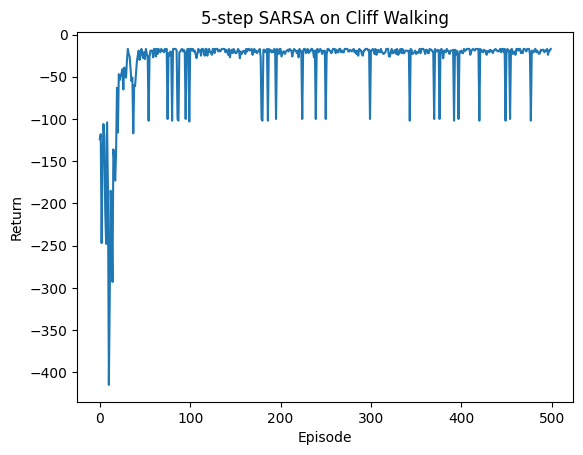

In [9]:
np.random.seed(0)
n_step = 5
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                agent.update(state, action, reward, next_state, next_action, done)
                state = next_state
                action = next_action
                episode_return += reward
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(10)

episode_return = list(range(len(return_list)))
plt.plot(episode_return, return_list)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title(f'{n_step}-step SARSA on Cliff Walking')
plt.show()

In [10]:
action_meaning = ['^', 'v', '<', '>']
print(f'Final policy derived from the Q-table by {n_step}-step Sarsa:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

Final policy derived from the Q-table by 5-step Sarsa:
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [12]:
class QLearning:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error
    

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2097.55it/s, episode=500, return=-61.700]


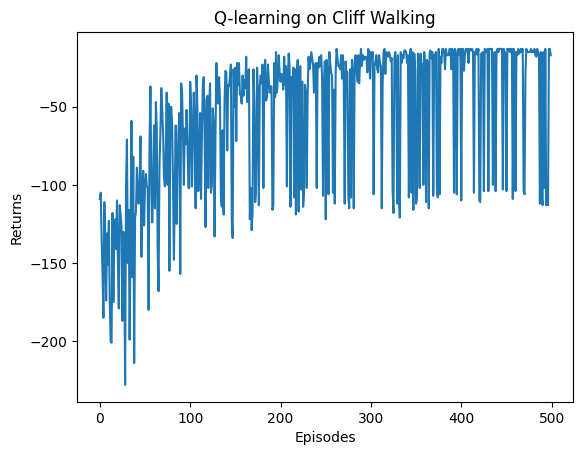

Final policy derived from the Q-table by Q-learning:
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [13]:
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500

return_list = [] 
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Final policy derived from the Q-table by Q-learning:')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])